# ARIMA and Seasonal ARIMA Workflow

### 1. Visualize the Time Series Data
* Plot the time series to understand its structure and any apparent patterns (trends, seasonality, etc.).
### 2. Make the Time Series Data Stationary
* Differencing: Apply differencing to remove trends and seasonality.
* Transformation: Apply transformations (e.g., log transformation) to stabilize the variance.
* Statistical Tests: Use tests like the Augmented Dickey-Fuller (ADF) test to check stationarity.
### 3. Plot the Correlation and AutoCorrelation Charts
* Autocorrelation Function (ACF): Plot to understand the lagged relationships in the data.
* Partial Autocorrelation Function (PACF): Plot to identify the order of the AR term.
### 4. Determine the Order of the Model (p, d, q)
* Based on ACF and PACF plots, determine the appropriate values for:
    * p (AR term): Number of lag observations included in the model.
    * d (differencing): Number of times the data needs to be differenced to make it stationary.
    * q (MA term): Number of lagged forecast errors in the prediction equation.
### 5. Construct the ARIMA Model or Seasonal ARIMA (SARIMA) Model
* ARIMA(p, d, q): Fit the ARIMA model using the identified parameters.
* SARIMA(p, d, q)(P, D, Q, m): Fit the seasonal ARIMA model if the data has seasonality, where:
    * P, D, Q: Seasonal components.
    * m: Number of time steps for a single seasonal period.
### 6. Model Diagnostics
* Residual Analysis: Check the residuals of the model to ensure they behave like white noise.
* Diagnostic Plots: Plot residuals, ACF of residuals, and Q-Q plots.
### 7. Use the Model to Make Predictions
* In-Sample Forecast: Validate the model by comparing the in-sample forecast with actual values.
* Out-of-Sample Forecast: Use the model to forecast future values.
### 8. Evaluate Model Performance
* Metrics: Calculate performance metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), etc.
* Visual Comparison: Plot actual vs. predicted values to visually assess the model’s performance.

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
df=pd.read_csv('./data/perrin-freres-monthly-champagne-.csv')

In [50]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [51]:
df.columns

Index(['Month', 'Perrin Freres monthly champagne sales millions ?64-?72'], dtype='object')

In [52]:
# rename columns
df = df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'})

In [53]:
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [54]:
def summary_df(df:pd.DataFrame) -> pd.DataFrame:
    """
    Generates a summary of the DataFrame including data types, counts, unique values,
    percentages of unique values, null counts, percentages of null values, and basic 
    statistics for numeric columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.

    Returns:
    pd.DataFrame: Summary DataFrame.
    """
    df_copy = df.copy()
    
    # Initialize an empty DataFrame to store summary information
    desc = pd.DataFrame(index=list(df_copy))

    desc['type'] = df_copy.dtypes
    desc['count'] = df_copy.count()
    desc['nunique'] = df_copy.nunique()
    desc['%unique'] = desc['nunique'] / len(df_copy) * 100
    desc['null'] = df_copy.isnull().sum()
    desc['%null'] = desc['null'] / len(df_copy) * 100
    
    # Concatenate summary statistics for numeric columns
    desc = pd.concat([desc, df_copy.describe().T.drop('count', axis=1)], axis=1)
    desc = desc.sort_values(by=['type', 'null'])
    
    return desc

In [55]:
desc_df = summary_df(df)
desc_df.style.background_gradient()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Sales,float64,105,103,96.261682,2,1.869159,4761.152381,2553.502601,1413.000000,3113.000000,4217.000000,5221.000000,13916.000000
Month,object,106,106,99.065421,1,0.934579,nan,nan,nan,nan,nan,nan,nan


## Data Cleaning

In [56]:
# show rows with missing values
df[df.isnull().any(axis=1)]

,Month,Sales
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [57]:
# Drop NaN values rows
df.dropna(inplace=True)

In [58]:
desc_df = summary_df(df)
desc_df.style.background_gradient()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Sales,float64,105,103,98.095238,0,0.000000,4761.152381,2553.502601,1413.000000,3113.000000,4217.000000,5221.000000,13916.000000
Month,object,105,105,100.000000,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [59]:
# convert month column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [60]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [61]:
# set month columns as index
df.set_index('Month', inplace=True)

In [62]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


## Data Visualization

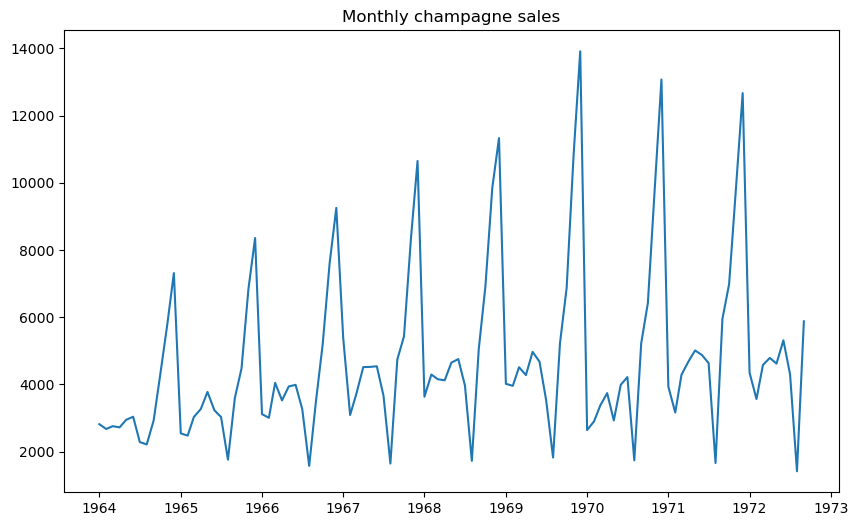

In [63]:
# plot the sales data
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.title('Monthly champagne sales')
plt.show()

Here i can see that the data looks seasonal data.

In [64]:
# Test for  (ADF Test)
from statsmodels.tsa.stattools import adfuller

In [65]:
test_result = adfuller(df['Sales'])

In [66]:
# Null Hypothesis (Ho): It is non stationary 
# Alternate Hypothesis (H1): It is stationary

def adfuller_test(dataframe:pd.Series):
    result= adfuller(dataframe)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05: # define p-value
        print("Conclusion: Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Conclusion: Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary. Accept the null hypothesis")

In [67]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276166
p-value : 0.36391577166024813
#Lags Used : 11
Number of Observations Used : 93
Conclusion: Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary. Accept the null hypothesis


So here, I accept the Null Hypothesis. The data is non stationary.

# Making Data Stationary

## Differencing

Differencing: Apply differencing to remove trends and seasonality.

In [68]:
df['Sales First Difference'] = df["Sales"] - df['Sales'].shift(1)

In [69]:
df['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [70]:
# Create a Seasonal First Difference by shifting the Sales column by 12 months since the seasonal is by 12 months
df['Seasonal First Difference'] = df['Sales'] - df['Sales'].shift(12)

In [71]:
df.head(20)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [72]:
# Test Augmented Dickey-Fuller (ADF) on Seasonal First Difference Columns
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
Conclusion: Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Now the data is stationary

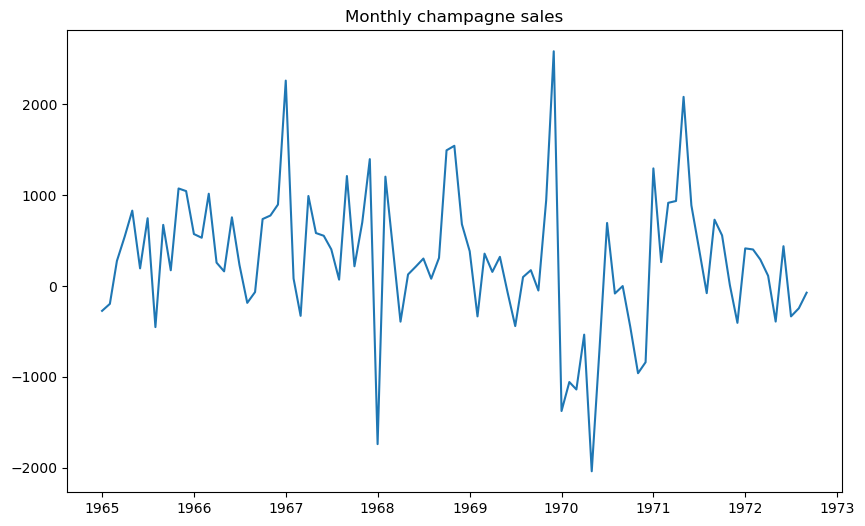

In [73]:
# plot the Seasonal First Difference data
plt.figure(figsize=(10, 6))
plt.plot(df["Seasonal First Difference"])
plt.title('Monthly champagne sales')
plt.show()

Here, I manage to remove the seasonal on the original sales data. We can continue with this data.

# 3. Plot the Correlation and AutoCorrelation Charts

An Auto Regressive (AR) model is a type of statistical model used for analyzing and forecasting time series data. The AR model specifies that the output variable depends linearly on its own previous values. Essentially, an AR model expresses the value of a variable as a linear function of its past values, plus a noise term.

The Usage: If i want to predict the sales of today, how many data should i consider.


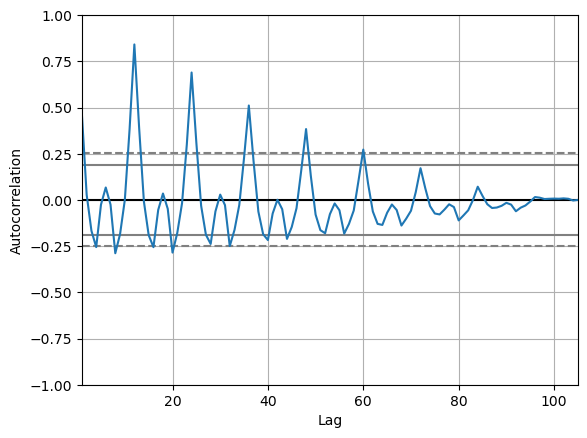

In [74]:
# from pandas.plotting.autocorrelation_plot import autocorrelation_plot
pd.plotting.autocorrelation_plot(df['Sales'])
plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an Auto Regressive (AR) model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an Moving Average (MA) model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q  
    p = AR model lags  
    d = differencing  
    q = MA lags  

In [75]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

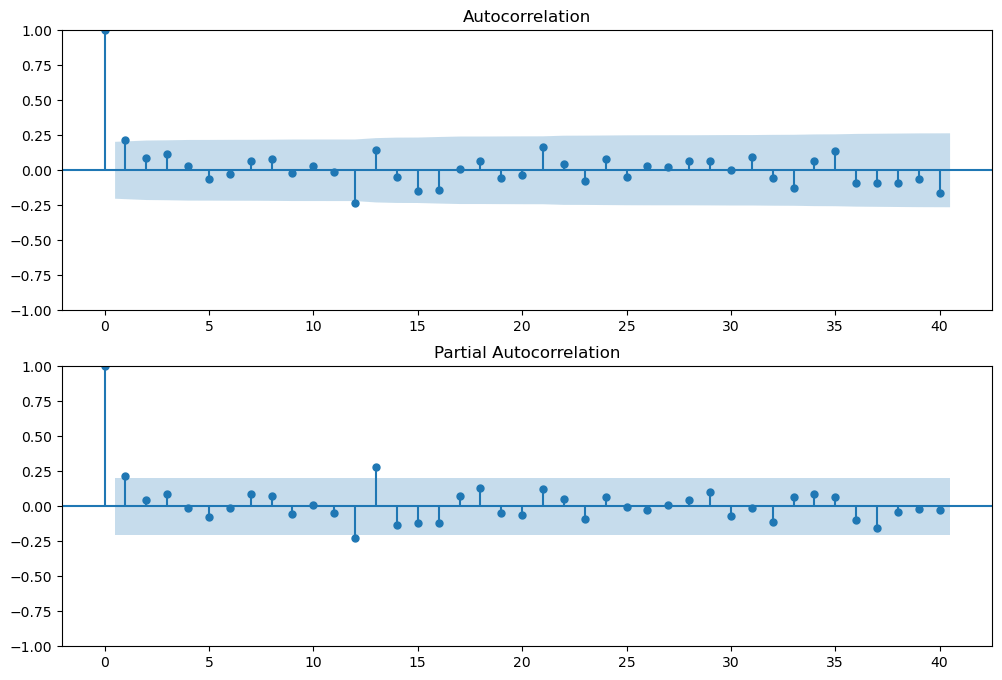

In [76]:
# 3. Plot the Correlation and AutoCorrelation Charts
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(df['Seasonal First Difference'].dropna(),lags=40, ax=ax[0])
plot_pacf(df['Seasonal First Difference'].dropna(),lags=40, ax=ax[1])
plt.show()

# 4. Determine the Order of the Model (p, d, q)
For non-seasonal (Seasonal First Difference) data,

From the PACF graph, p = 1,  
From the ACF graph, q = 0
d = 12

For seasonal data (Sales) - For experimentation purpose, I will run ARIMA on the native Sales Data.

## Experiment with SALES Data

In [77]:
# For non-seasonal data
# p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

In [78]:
# create new copy of df
df_test = df.copy()

In [79]:
p=1 
d=1
q=1

model=ARIMA(df_test['Sales'],order=(p,d,q))
model_arima_fit=model.fit()

/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [80]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Wed, 15 May 2024   AIC                           1911.627
Time:                        23:36:04   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.0

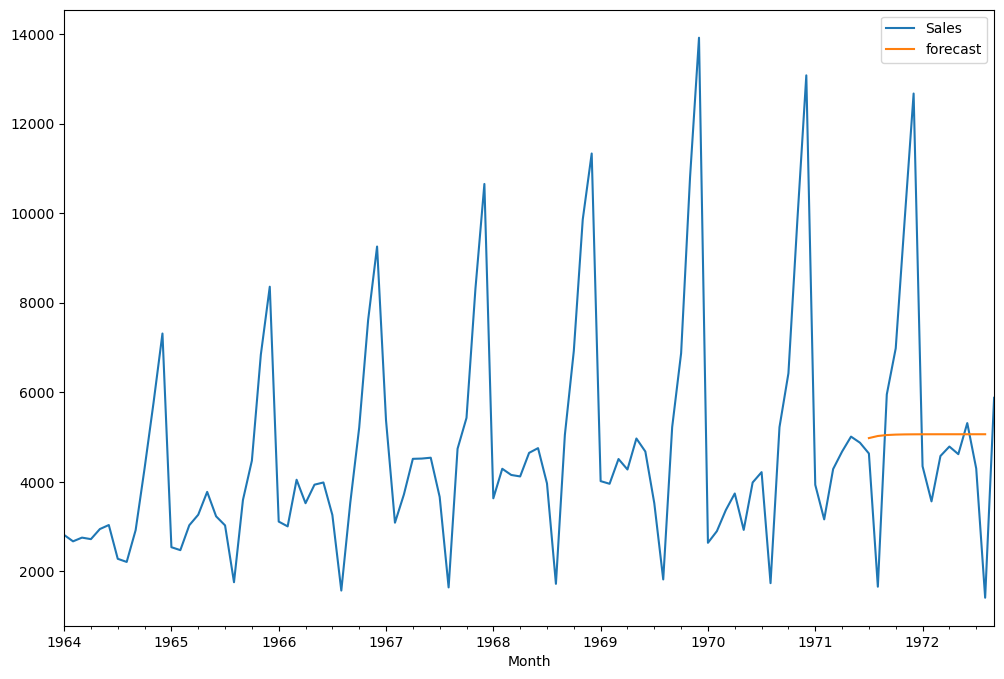

In [81]:
df_test['forecast']=model_arima_fit.predict(start=90,end=103,dynamic=True)
df_test[['Sales','forecast']].plot(figsize=(12,8))
plt.show()

The experiment method is not correct since I did not include seasonal in the data. Hence the correct way i using SARIMAX

In [82]:
df_test.tail(10)

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1971-12-01,12670.0,2819.0,-406.0,5061.248925
1972-01-01,4348.0,-8322.0,414.0,5062.157248
1972-02-01,3564.0,-784.0,402.0,5062.570076
1972-03-01,4577.0,1013.0,291.0,5062.757705
1972-04-01,4788.0,211.0,112.0,5062.842982
1972-05-01,4618.0,-170.0,-392.0,5062.881739
1972-06-01,5312.0,694.0,438.0,5062.899355
1972-07-01,4298.0,-1014.0,-335.0,5062.907361
1972-08-01,1413.0,-2885.0,-246.0,5062.910999


# Using SARIMA

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [84]:
# create new copy of df
df_sarimax = df.copy()

In [85]:
# Identify the order (p, d, q) and seasonal order (P, D, Q, m)
p = 1  # Based on PACF plot
d = 1  # Based on differencing
q = 1  # Based on ACF plot
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal MA order
m = 12  # Monthly data implies 12 periods per season

In [86]:
# Fit the SARIMAX Model
# Here I train the model with the whole dataset
model = SARIMAX(df_sarimax['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
model_sarima_result = model.fit()
print(model_sarima_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02513D+00    |proj g|=  1.67954D-01

At iterate    5    f=  5.98974D+00    |proj g|=  3.49906D-02

At iterate   10    f=  5.98497D+00    |proj g|=  4.94792D-02

At iterate   15    f=  5.98162D+00    |proj g|=  1.26235D-03

At iterate   20    f=  5.98162D+00    |proj g|=  1.72940D-03

At iterate   25    f=  5.98147D+00    |proj g|=  2.12048D-02

At iterate   30    f=  5.97815D+00    |proj g|=  6.08022D-02

At iterate   35    f=  5.97678D+00    |proj g|=  3.60782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


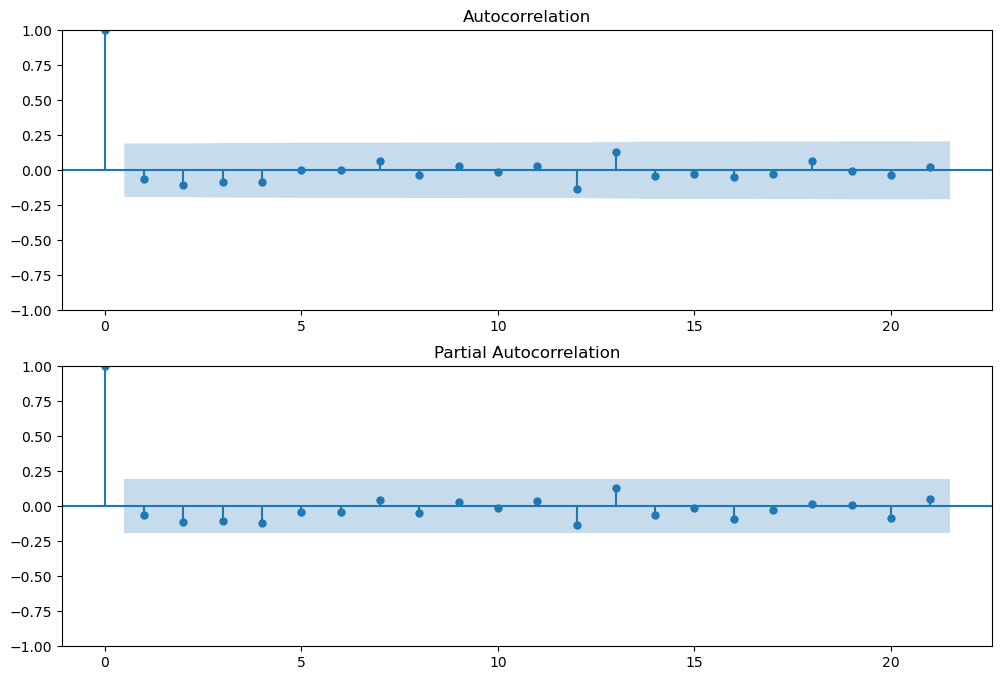

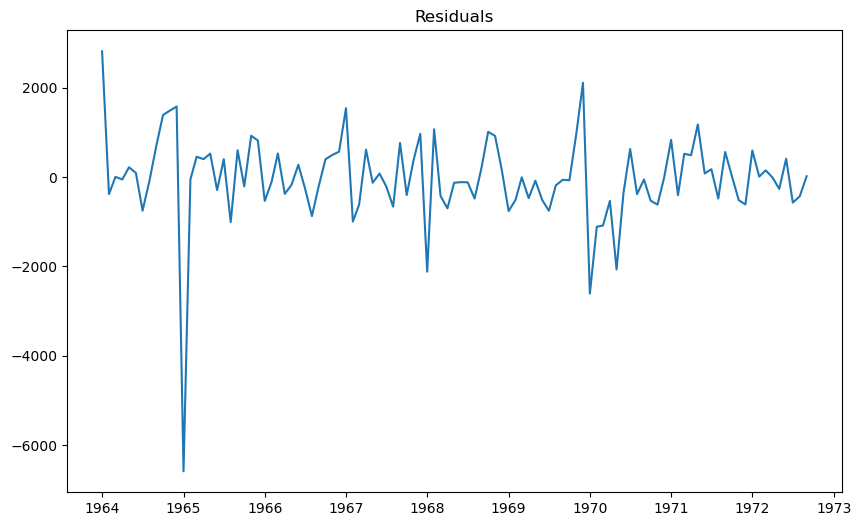

In [87]:
# Diagnostic Checking
residuals = model_sarima_result.resid
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

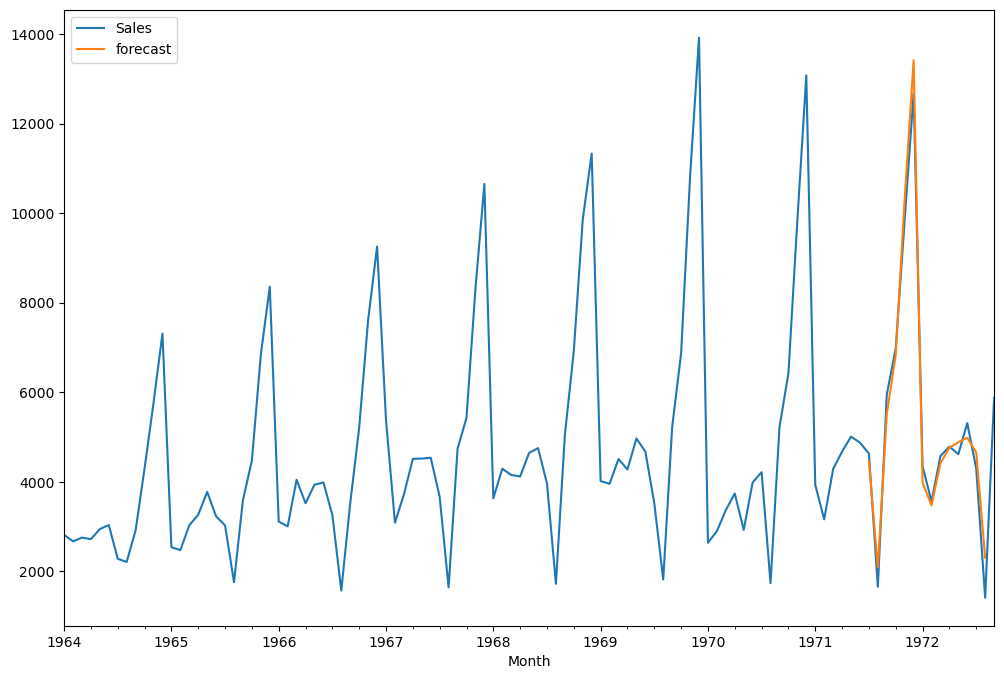

In [88]:
df_sarimax['forecast']= model_sarima_result.predict(start=90,end=103,dynamic=True)
df_sarimax[['Sales','forecast']].plot(figsize=(12,8))
plt.show()

# 7. Make Prediction (Future)

In [89]:
# Forecasting for the next 12 months
forecast_steps = 12
forecast = model_sarima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [90]:
# Create a DataFrame for the forecasted values (12 months)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=df.columns)

# Combine the original and forecasted DataFrames
combined_df = pd.concat([df, forecast_df], axis=0)

In [91]:
combined_df.tail(15)

,Sales,Sales First Difference,Seasonal First Difference
1972-07-01,4298.0,-1014.0,-335.0
1972-08-01,1413.0,-2885.0,-246.0
1972-09-01,5877.0,4464.0,-74.0
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN


In [92]:
# store forecast_value in combine_df
combined_df['forecast'] = forecast_values

In [93]:
combined_df

,Sales,Sales First Difference,Seasonal First Difference,forecast
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN
...,...,...,...,...
1973-05-01,NaN,NaN,NaN,4862.330323
1973-06-01,NaN,NaN,NaN,5389.556090
1973-07-01,NaN,NaN,NaN,4598.383474
1973-08-01,NaN,NaN,NaN,1736.119221


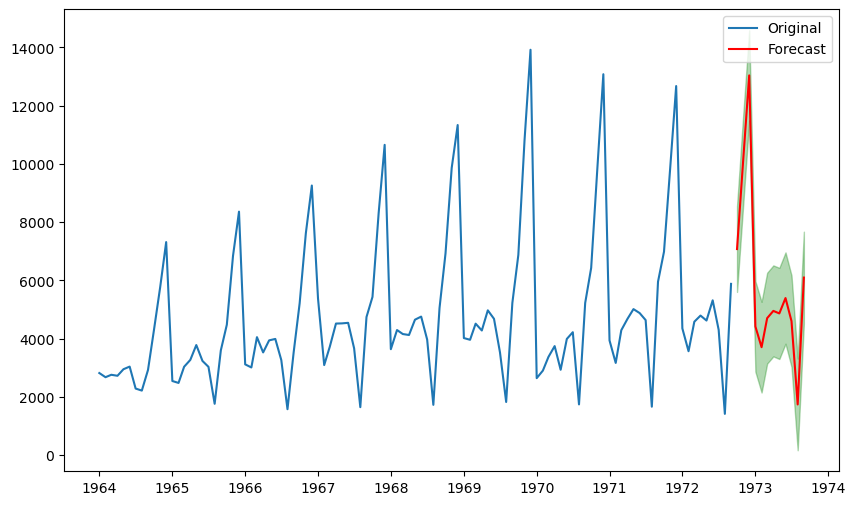

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Sales'], label='Original')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.show()

# 8. Evaluate Model Performance

Above I train the SARIMAX model will the whole dataset and then predict for the next 12 months.  
However, I did not evaluate the model performance.  
So here, instead of train the whole dataset, I will train using train/test split of 80%. Train the SARIMAX model on the train data and then evaluate on the test data.


In [105]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [106]:
# Identify the order (p, d, q) and seasonal order (P, D, Q, m)
p = 1  # Based on PACF plot
d = 1  # Based on differencing
q = 1  # Based on ACF plot
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal MA order
m = 12  # Monthly data implies 12 periods per season

In [107]:
# Fit the SARIMAX Model
model = SARIMAX(train['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
model_sarima_result = model.fit()
print(model_sarima_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63007D+00    |proj g|=  2.32230D-01

At iterate    5    f=  5.52277D+00    |proj g|=  4.50974D-02

At iterate   10    f=  5.51777D+00    |proj g|=  2.45836D-02

At iterate   15    f=  5.50239D+00    |proj g|=  6.11739D-02

At iterate   20    f=  5.50135D+00    |proj g|=  1.78343D-04

At iterate   25    f=  5.50134D+00    |proj g|=  5.03047D-03

At iterate   30    f=  5.50003D+00    |proj g|=  5.71738D-02

At iterate   35    f=  5.48680D+00    |proj g|=  2.44231D-02

At iterate   40    f=  5.48656D+00    |proj g|=  1.10544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ofotech_fitri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [108]:
# Make in-sample predictions on the training data
train_pred = model_sarima_result.get_prediction(start=train.index[0], end=train.index[-1])
train_pred_mean = train_pred.predicted_mean

In [109]:
# Make out-of-sample predictions on the test data
test_steps = len(test)
forecast = model_sarima_result.get_forecast(steps=test_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [111]:
# Calculate performance metrics
mae = mean_absolute_error(test['Sales'], forecast_mean)
mse = mean_squared_error(test['Sales'], forecast_mean)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 1244.8219561417955
MSE: 1934701.37178983
RMSE: 1390.9354304890755


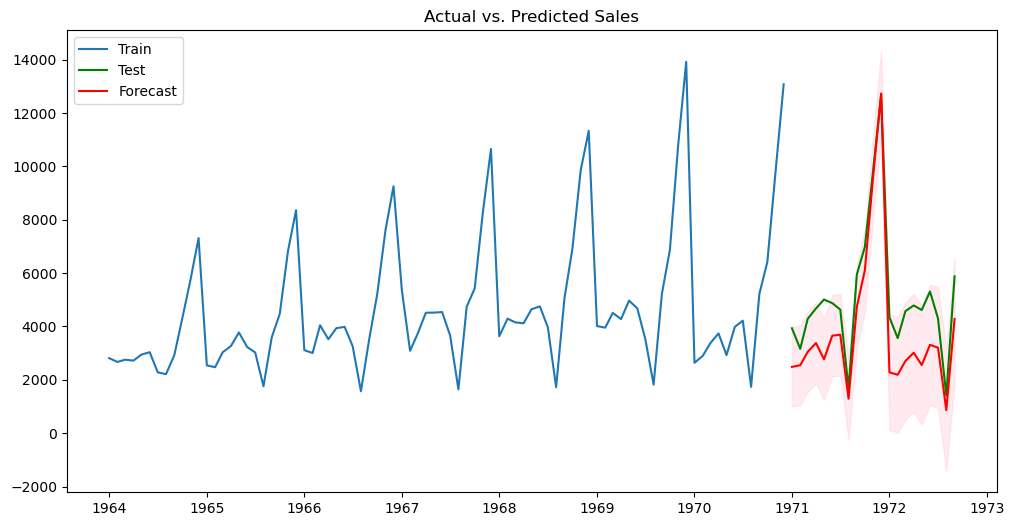

In [112]:
# Visual comparison of actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index, test['Sales'], label='Test', color='green')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Actual vs. Predicted Sales')
plt.show()

# Conclusion

1. This exercise demonstrate the basic fundamental of using ARIMA in time-series-forecasting.
2. For seasonal data, we can use Differencing technique to remove trend and seasonality.
3. Use SARIMA instead for seasonal data use case.